### This notebook is designed for evaluating probabilistic time-series predictions

In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '4'


import pickle
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from datetime import datetime
import matplotlib.pyplot as plt
from data.serialize import serialize_arr, deserialize_str, SerializerSettings
from ipywidgets import interact
import numpy as np
import torch
from models.ICL import MultiResolutionPDF
from scipy.stats import norm

import pickle
import os
if not os.path.exists('MultiPDFList'):
    os.makedirs('MultiPDFList')

# Check if directory exists, if not create it
if not os.path.exists('plot_output'):
    ### dump pickled torch files here for later plotting
    os.makedirs('plot_output')
    
if not os.path.exists('gif_plots'):
    ### dump generated GIFs
    os.makedirs('gif_plots')


### Generate Dynamical Systems Data

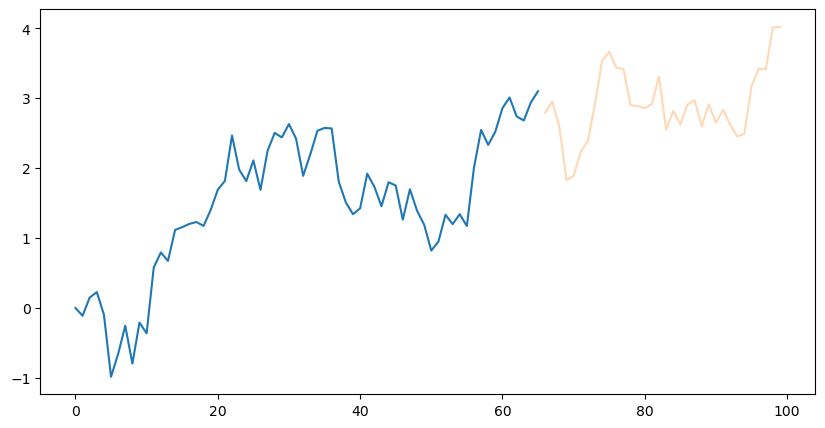

In [2]:
### Drift-Diffusion SDE

# Time discretization
# Nt = 1000 # number of steps
Nt = 100 # number of steps
dt =  0.2 # time step
tspan = np.linspace(0, Nt*dt, Nt)

# Drift and diffusion parameters
# Drift rate
np.random.seed(6)
# a = 0.3  
a = 0
# Noise level
sigma = 0.8

# Initialize the time series
x = 0  # Starting point
time_series = [x]
mean_series = [x]
sigma_series = [0]

# Generate the drift-diffusion time series
for t in range(1, Nt):
    x_mean = x + a*dt
    x_sigma = sigma * np.sqrt(dt)
    dW =  np.random.normal()  # Wiener process (Brownian motion)
    x = x_mean + x_sigma * dW
    
    time_series.append(x)
    mean_series.append(x_mean)
    sigma_series.append(x_sigma)
    
# Store the generated time-series in a pandas DataFrame
df = pd.DataFrame({'X': time_series})

# Split the data into training and testing sets
train = df['X'][0:int(Nt/3*2)]
test = df['X'][int(Nt/3*2):]

plt.figure(figsize=(10, 5))
plt.plot(train, alpha = 1)
plt.plot([np.nan]*len(train)+list(test), alpha = 0.3)



## Running LLMTime and extracing logits

### Convert time series to strings

In [3]:
prec = 3
settings=SerializerSettings(base=10, prec=prec, signed=True, time_sep=',', bit_sep='', minus_sign='-', fixed_length=True, max_val = 10)

from data.serialize import serialize_arr
X = np.append(train.values, test.values) 
rescale_factor = 0.6
up_shift = 0.15

rescaled_array = (X-X.min())/(X.max()-X.min()) * rescale_factor + up_shift
rescaled_true_mean_arr = (np.array(mean_series)-X.min())/(X.max()-X.min()) * rescale_factor + up_shift
rescaled_true_sigma_arr = np.array(sigma_series)/(X.max()-X.min()) * rescale_factor 

full_series = serialize_arr(rescaled_array, settings)
full_array = deserialize_str(full_series, settings) * 10

full_series = full_series.lstrip('0').replace(',0', ',')


In [4]:
full_series

'267,254,285,295,256,149,189,237,172,242,224,337,363,348,401,406,412,415,408,435,470,485,563,505,485,520,470,537,568,560,583,558,494,531,571,576,575,484,448,428,438,498,475,442,483,477,419,471,434,410,366,381,427,411,428,408,508,573,547,570,610,628,596,589,620,639,602,621,578,487,494,535,554,617,692,707,679,677,615,614,610,617,664,573,605,582,616,624,579,617,585,607,582,561,566,648,678,677,748,749,'

In [5]:
len(full_series)

400

Cache common prompt: https://github.com/ggerganov/llama.cpp/pull/3228

define full series
For value in sequence: <br>    
    initialize multi_digit_pdf object <br>
    for digit in value: <br>
        initialize 10 synthetic sequences of the same length <br>
        generate synthetic sequence <br>

In [6]:
import torch
torch.cuda.empty_cache()
from models.llama import get_model_and_tokenizer, get_tokenizer

model, tokenizer = get_model_and_tokenizer('13b')


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
batch = tokenizer(
        [full_series], 
        return_tensors="pt",
        add_special_tokens=True        
    )


### Compute High Resolution Logits

In [14]:
with torch.no_grad():
    out = model(batch['input_ids'].cuda(), use_cache=True)

logit_mat = out['logits'] 
kv_cache_main = out['past_key_values']

# with open(f"plot_output/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl", 'wb') as f:
#             pickle.dump(logit_mat, f)

In [17]:
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))
if torch.cuda.is_available():
    print("Cuda is available")
else:
    print("Cuda is not available")



0
NVIDIA RTX A4000
Cuda is available


In [20]:
len(kv_cache_main[0])

2

### Load saved logits

In [9]:
### Take out only the good tokens, which is equivalent to setting bad tokens to -inf
# good_tokens_str = list("0123456789" + settings.time_sep + settings.bit_sep)
good_tokens_str = list("0123456789")
good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
logit_mat_good = logit_mat[:,:,good_tokens].clone()

### Plot MultiResolution Dist, and calculate loss

In [31]:
def trim_kv_cache(past_key_values, desired_length):
    """
    Trims the past_key_values cache along the sequence length dimension.
    Parameters:
        past_key_values (tuple): The original past_key_values cache, a nested tuple structure where
                                 each tuple corresponds to a layer in the transformer and contains
                                 two tensors: the key and value states.
        desired_length (int): The sequence length up to which you want to keep the cache.

    Returns:
        tuple: A new past_key_values cache where key and value states have been trimmed to the
               desired_length. The returned structure is a tuple of tuples.
    """    
    if past_key_values is None:
        return None
    trimmed_past_key_values = []
    for layer_past in past_key_values:
        # Each layer_past is a tuple (key_states, value_states)
        key_states, value_states = layer_past
        # Trim key_states and value_states along the sequence length dimension
        key_states = key_states[..., :desired_length, :]
        value_states = value_states[..., :desired_length, :]
        trimmed_past_key_values.append((key_states, value_states))
    return tuple(trimmed_past_key_values)

def next_token_prob_from_series(full_series, model = model, tokenizer = tokenizer, T=1, kv_cache = None, load_cache_to_cpu = False):
    """
    This function calculates the probability of the next token in a series.

    Parameters:
        full_series (str): The series of tokens.
        model (transformer): The transformer model to use for prediction.
        tokenizer (tokenizer): The tokenizer to use for tokenizing the series.
        T (int): Temperature parameter for softmax function. Default is 1.
        kv_cache (dict): The key-value cache for states [0:-1]

    Returns:
        tuple: A tuple containing the probabilities of the next token and the new key-value cache.
    """
    batch = tokenizer(
        [full_series], 
        return_tensors="pt",
        add_special_tokens=True
    )
    ### Put batch to cuda
    if kv_cache is None:
        with torch.no_grad():
            out = model(batch["input_ids"].cuda(), use_cache=True)
    else:
        if load_cache_to_cpu:
            kv_cache = tuple(tuple(x.cuda() for x in sub_tuple) for sub_tuple in kv_cache)
        with torch.no_grad():
            out = model(batch["input_ids"][:,-1:].cuda(), use_cache=True, past_key_values = kv_cache)

    logit_mat = out['logits'] 
    if load_cache_to_cpu:
        kv_cache_new = tuple(tuple(x.cpu() for x in sub_tuple) for sub_tuple in out['past_key_values'])
    else:
        kv_cache_new = out['past_key_values']
    probs = torch.nn.functional.softmax(logit_mat[0,-1,good_tokens].clone().cpu(), dim = 0).numpy()
    return (probs, kv_cache_new)


In [25]:
def recursive_refiner(PDF, seq, curr = -prec, refine_depth = -2, main = True, mode = "neighbor"
                , model = model, tokenizer = tokenizer, kv_cache = None):
    """
    Recursively refines the PDF until desired depth

    Parameters:
        PDF (MultiResolutionPDF): The PDF to be refined.
        seq (str): must end with a number, not comma
        curr (int): The current precision. Default is -prec.
        refine_depth (int): The depth of refinement. Default is -2.
        main (bool): Whether the current sequence is on the main branch    
        kv_cache: cache of seq[0:-1]
        mode (str): "neighbor" or "all"
        model: transformer used for refinement.

    Returns:
    None
    """
    if curr == refine_depth:
        print("nothing to refine, terminate refiner")
        return
    if main:
        main_digit = seq[curr]
        trimmed_seq = seq[:curr]
 
        if mode == "neighbor":
            # 2 off branches
            if curr < -1:
                trimmed_kv_cache = trim_kv_cache(kv_cache, curr+1)       
            for alt_digit in [int(main_digit) - 1, int(main_digit) + 1]:
                if alt_digit not in [10, -1]:
                    alt_seq = trimmed_seq + str(alt_digit)
                    recursive_refiner(PDF, alt_seq, curr, refine_depth, main = False, mode = mode, kv_cache = trimmed_kv_cache) 
                    
        if mode == "all":
            # 9 off branches
            if curr < -1:
                trimmed_kv_cache = trim_kv_cache(kv_cache, curr+1)       
            for alt_digit in range(0, 9):
                if alt_digit != int(main_digit):
                    alt_seq = trimmed_seq + str(alt_digit)
                    recursive_refiner(PDF, alt_seq, curr, refine_depth, main = False, mode = mode, kv_cache = trimmed_kv_cache)   
            
        if curr < refine_depth - 1:
            # skip to next main branch
            # no need to trim cache
            recursive_refiner(PDF, seq, curr+1, refine_depth, mode = "all", main = True, kv_cache = kv_cache)
    else:
        # ready to evaluate
        probs, kv_cache_new = next_token_prob_from_series(seq, kv_cache = kv_cache)
        last_comma_location = seq.rfind(',')
        num_slice = seq[last_comma_location+1:]
        last_digit_PDF = MultiResolutionPDF()
        last_digit_PDF.load_from_prec_digits_prob(num_slice, probs)
        PDF.refine(last_digit_PDF)
        if curr < refine_depth - 1:
            # 10 off branch
            for i in range(10):
                alt_seq = seq + str(i)
                recursive_refiner(PDF, alt_seq, curr+1, refine_depth, main = False, mode = mode, kv_cache = kv_cache_new) 

In [28]:
### 2min49 ~ 2min57 sec without cache
### 26 sec with cache
T = 1
probs = torch.nn.functional.softmax(logit_mat_good[:,1:,:] / T, dim=-1)

PDF_list = []
comma_locations = np.sort(np.where(np.array(list(full_series)) == ',')[0])

for i in range(len(comma_locations)):
    # print(i)
    PDF = MultiResolutionPDF()
    # slice out the number before ith comma
    if i == 0:
        start_idx = 0
    else:
        start_idx = comma_locations[i-1]+1
    end_idx = comma_locations[i]
    num_slice = full_series[start_idx:end_idx]
    prob_slice = probs[0,start_idx:end_idx].cpu().numpy()
    ### Load hierarchical PDF 
    PDF.load_from_num_prob(num_slice, prob_slice)
    PDF_list += [PDF]
    
    ### Refine hierarchical PDF
    seq = full_series[:end_idx]
    # cache and full_series are shifted from beginning, not end
    end_idx_neg = end_idx - len(full_series)
    # kv cache contains seq[0:-1]
    kv_cache = trim_kv_cache(kv_cache_main, end_idx_neg-1)
    recursive_refiner(PDF, seq, curr = -prec, main = True, refine_depth = -2, mode = "neighbor", kv_cache = kv_cache)
    
        
    
    
    

In [36]:
### without caching, 53.4 seconds
### with cpu caching, 23.6 - 23.7 seconds
### with gpu caching, 20.6 seconds
### with gpu caching, 4 seconds
import time
start_time = time.time()
for i in range(len(comma_locations)):
    PDF = MultiResolutionPDF()
    # slice out the number before ith comma
    if i == 0:
        start_idx = 0
    else:
        start_idx = comma_locations[i-1]+1
    end_idx = comma_locations[i]
    num_slice = full_series[start_idx:end_idx]
    ### Refine hierarchical PDF

    
    seq = full_series[:end_idx]

    ### Load hierarchical PDF 
    PDF_list[i] = MultiResolutionPDF()
    PDF_list[i].load_from_num_prob(num_slice, prob_slice)
    ### prepare initial cache
    end_idx_neg = end_idx - len(full_series)
    kv_cache = trim_kv_cache(kv_cache_main, end_idx_neg-1)        
    ### Refine hierarchical PDF 
    recursive_refiner(PDF_list[i], seq, curr = -prec, main = True, refine_depth = -1, mode = "neighbor", kv_cache=kv_cache)

end_time  = time.time()
time_lapsed = end_time- start_time
print(f"time taken :{time_lapsed}")
    

In [28]:
### Pickle PDF_list

with open(f"MultiPDFList/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl", 'wb') as f:
    pickle.dump(PDF_list, f)

In [35]:

### Load multiple digits to MultiResolutionPDF

log_scale = 0
plot1_log_scale = 0

### Plot distribution before ith comma
def digiprob_plotter(comma_idx=1):
    if i == 0:
        start_idx = 0
    else:
        start_idx = comma_locations[i-1]+1
    fig, axs = plt.subplots(2, 1, figsize=(12, 6))
    # Adjust the horizontal space between subplots
    plt.subplots_adjust(hspace=0.4)
    # Plot the full array with a marker on the selected value
    axs[0].plot(X, marker='o', color='black', markersize=3, lw = '0.1')
    axs[0].plot(comma_idx-1, X[comma_idx-1], color='r', marker='o')
    if plot1_log_scale:
        axs[0].set_yscale('log')
    # Plot softmax distributions for each digit
    
    axs[1].set_xlabel("Digit")
    axs[1].set_ylabel("Probability Density")
    axs[1].set_title(full_series[start_idx-30:start_idx] + "?")      
    PDF_list[comma_idx].compute_stats()
    PDF_list[comma_idx].plot(ax = axs[1], log_scale=log_scale)
    
    # characterizing ground truth distribution
    true_mean = rescaled_true_mean_arr[comma_idx] * 10
    true_sigma = rescaled_true_sigma_arr[comma_idx] * 10
    x_values = np.linspace(0, 10, 300)
    gaussian = norm.pdf(x_values, true_mean, true_sigma)
    axs[1].plot(x_values, gaussian, color = 'r', label = 'Truth')
    axs[1].vlines(true_mean, 0, np.max(gaussian), color = 'r')
    # axs[1].set_ylim(np.min(pdf.bin_height_arr), np.max(gaussian)*1.7)
    axs[1].legend()
    axs[1].set_ylim(0,2.5)
    # return fig

# Adjust the range of the slider to match the number of commas in the series
num_commas = full_series.count(',')
interact(digiprob_plotter, comma_idx=(0, num_commas-1, 1))

interactive(children=(IntSlider(value=1, description='comma_idx', max=99), Output()), _dom_classes=('widget-in…

<function __main__.digiprob_plotter(comma_idx=1)>

### Mean and mode error as in-context loss function

In [43]:
### Use MultiResolutionPDF to define loss 

T = 1
# discard first token
probs = torch.nn.functional.softmax(logit_mat_good[:,1:,:] / T, dim=-1)
string_labels = [label for label in good_tokens_str]
good_tokens_len = len(good_tokens_str)

def multi_resolution_predictor(comma_idx=1):
    # Ensure comma_idx is within a valid range
    comma_idx = max(1, min(comma_idx, full_series.count(',') + 1))

    # Find the start and end indices of the value at the comma_idx-th comma
    comma_count = 0
    start_idx = None
    end_idx = None
    for i, char in enumerate(full_series):
        if char == ',':
            comma_count += 1
            if comma_count == comma_idx:
                start_idx = i + 1
            elif comma_count == comma_idx + 1:
                end_idx = i 
                break


    if start_idx is not None and end_idx is None:
        end_idx = len(full_series)

    # Calculate the number of digits to display in the softmax plot
    num_digits = end_idx - start_idx
    pdf = MultiResolutionPDF()
    
    left_edge = 0
    previous_digit = 0
    previous_digit_prob = 1
    for i in range(num_digits):
        w = 0.1**i
        digit_idx = start_idx + i
        left_edge = left_edge + previous_digit * 10 * w
        x_coords = np.linspace(left_edge,left_edge+10 * w,good_tokens_len, endpoint = False) + 0.5 * w
        curr_digit = int(full_series[digit_idx])
        pdf_array = probs[:, digit_idx].cpu().numpy()[0]*previous_digit_prob/w
        ### save probability of the current digit, which is used to calculate the unconditioned PDF of the next digit
        curr_digit_prob = probs[:, digit_idx].cpu().numpy()[0][curr_digit]     
        previous_digit = curr_digit       
        previous_digit_prob = previous_digit_prob*curr_digit_prob
    
        # delete bins of the current digit unless it is the last digit
        if i < num_digits - 1:
            pdf_array  = np.delete(pdf_array , curr_digit)
            x_coords = np.delete(x_coords, curr_digit)
        
        pdf.add_bin(center_arr = x_coords, 
                    width_arr = np.ones(len(x_coords))*w, 
                    height_arr = pdf_array )


    pdf.normalize()
    pdf.compute_stats()
    return (pdf.mean, pdf.mode, pdf.sigma)


mean_arr = []
mode_arr = []
sigma_arr = []

num_commas = full_series.count(',')
for comma_idx in range(num_commas):
    mean, mode, sigma = multi_resolution_predictor(comma_idx)
    mean_arr.append(mean)
    mode_arr.append(mode)
    sigma_arr.append(sigma)

# Convert lists to numpy arrays
mean_arr = np.array(mean_arr)
mode_arr = np.array(mode_arr)
sigma_arr = np.array(sigma_arr)


### Sigma as an indicator of local lyapunov 

(-0.047806551651008534,
 1.003937584671179,
 -0.0423112762058814,
 0.8885368003235092)

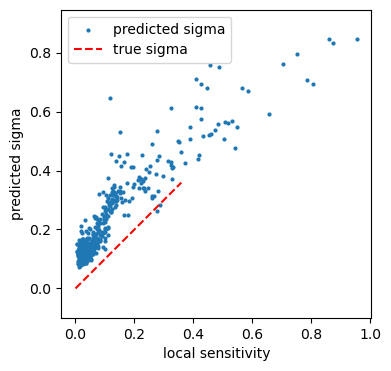

In [48]:
# plt.figure(figsize=(3, 6))
plt.figure(figsize=(4, 4))
plt.scatter(rescaled_true_sigma_arr[300:] * 10,sigma_arr[300:], marker='.', lw=0, label = 'predicted sigma')

# max_val = np.max(rescaled_true_sigma_arr[500:])*10
# min_val = np.min(rescaled_true_sigma_arr[500:])*10

max_val = np.max(sigma_arr[500:])
# min_val = np.min(sigma_arr[500:])
min_val = 0
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label = 'true sigma')  # Add line of slope 1

# plt.xlabel(r'true sigma $\sim$ local lyapunov')
plt.xlabel(r'local sensitivity')

plt.ylabel('predicted sigma')
# plt.xlim(0, 0.5)
# plt.ylim(0, 0.5)
plt.legend()
plt.axis('equal')
# plt.loglog()


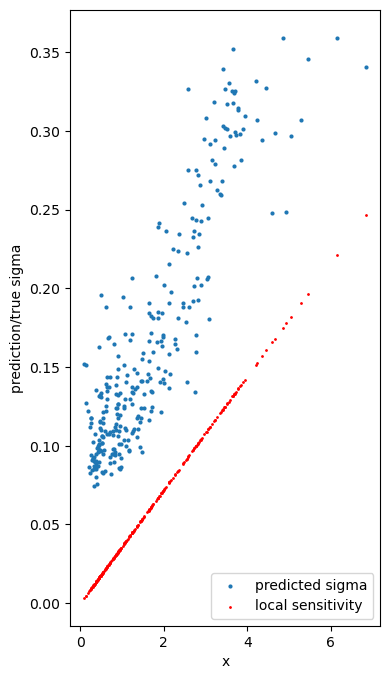

In [45]:
plt.figure(figsize=(4, 8))
plt.scatter(time_series[500:-1],sigma_arr[501:], marker = '.', lw=0, label = 'predicted sigma')
plt.scatter(time_series[500:-1],rescaled_true_sigma_arr[501:]*10, color='red', s = 1, label = 'local sensitivity')
plt.xlabel('x')
plt.ylabel('prediction/true sigma')
plt.legend()
# plt.yscale('log')
# plt.loglog()
# plt.xlim(0, 0.7)
# plt.xlim(0, 0.7)

### Plot all in-context loss functions

In [22]:
good_tokens_str = list("0123456789" + settings.time_sep + settings.bit_sep)
good_tokens = [tokenizer.convert_tokens_to_ids(token) for token in good_tokens_str]
bad_tokens = [i for i in range(len(tokenizer)) if i not in good_tokens]
logit_mat_biased = logit_mat.clone()
logit_mat_biased[:,:,bad_tokens] = -np.inf


logprobs = torch.nn.functional.log_softmax(logit_mat_biased, dim=-1)[0][:-1]
# logprob of the full trajectory
logprobs = logprobs[torch.arange(len(input_ids)), input_ids].cpu().numpy()
NLL = -logprobs

char_array = np.array(list(full_series))
comma_locations = np.where(char_array == ',')[0][:-1]+1

NLL_digit = -logprobs[comma_locations] \
            -logprobs[comma_locations+1] \
            -logprobs[comma_locations+2]

/tmp/ipykernel_661136/1163754128.py:38: RuntimeWarning: divide by zero encountered in log
  BT_loss = error_mode / (true_sigma_arr**2 + sigma_arr**2) / 2 + np.log(sigma_arr + true_sigma_arr) - np.log(sigma_arr * true_sigma_arr)/2 - np.log(2)
/tmp/ipykernel_661136/1163754128.py:41: RuntimeWarning: divide by zero encountered in divide
  KL_loss = np.log(sigma_arr/true_sigma_arr) + (true_sigma_arr**2 + error_mode)/(2*sigma_arr**2) - 1/2


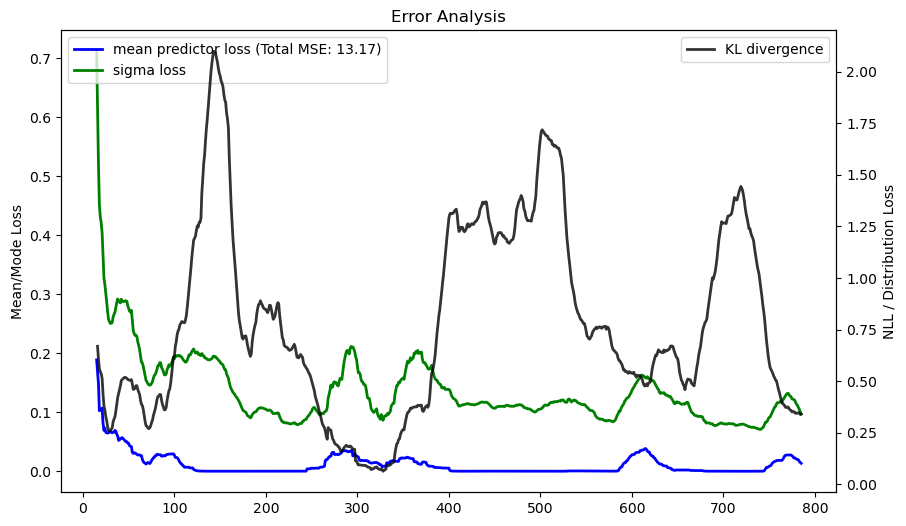

In [53]:
window_size = 30
xlog = 0
ylog = 0
scale_mean_mode_error = 0

true_mean_arr = rescaled_true_mean_arr*10
true_sigma_arr = rescaled_true_sigma_arr*10

top_hat_kernel = np.ones(window_size) / window_size
gaussian_kernel = norm.pdf(np.arange(window_size), loc=window_size // 2, scale=window_size / 6)
# kernel = gaussian_kernel
kernel = top_hat_kernel

# Errors for mean_arr
if scale_mean_mode_error:   
    error_mean = np.abs(true_mean_arr - mean_arr) / true_mean_arr
else:
    error_mean = (true_mean_arr - mean_arr) ** 2
averaged_error_mean = np.convolve(error_mean, kernel, mode='valid')

# Errors for mode_arr

if scale_mean_mode_error:   
    error_mode = np.abs(true_mean_arr - mode_arr) / true_mean_arr
else:
    error_mode = (true_mean_arr - mode_arr) ** 2
    
averaged_error_mode = np.convolve(error_mode, kernel, mode='valid')

# Errors sigma
error_sigma = np.abs(true_sigma_arr - sigma_arr) #/ true_sigma_arr
averaged_error_sigma = np.convolve(error_sigma, kernel, mode='valid')

# Errors for NLL
averaged_nll_digit = np.convolve(NLL_digit, kernel, mode='valid')

# Errors for Bhattacharya distance and KL divergence
BT_loss = error_mode / (true_sigma_arr**2 + sigma_arr**2) / 2 + np.log(sigma_arr + true_sigma_arr) - np.log(sigma_arr * true_sigma_arr)/2 - np.log(2)
averaged_BT_loss = np.convolve(BT_loss, kernel, mode='valid')

KL_loss = np.log(sigma_arr/true_sigma_arr) + (true_sigma_arr**2 + error_mode)/(2*sigma_arr**2) - 1/2
averaged_KL_loss = np.convolve(KL_loss, kernel, mode='valid')

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the averaged errors
# ax1.plot(np.arange(window_size//2, len(error_mode) - window_size//2 + 1), averaged_error_mode, label=f"mode predictor loss (Total MSE: {np.sum(error_mode):.2f})", linewidth=2, c='lightblue')
ax1.plot(np.arange(window_size//2, len(error_mean) - window_size//2 + 1), averaged_error_mean, label=f"mean predictor loss (Total MSE: {np.sum(error_mean):.2f})", linewidth=2, c='blue')
ax1.plot(np.arange(window_size//2, len(error_sigma) - window_size//2 + 1), averaged_error_sigma, label=f"sigma loss", linewidth=2, c='green')

ax1.set_ylabel("Mean/Mode Loss")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
# ax2.plot(np.arange(window_size//2, len(NLL_digit) - window_size//2 + 1), averaged_nll_digit, label="NLL Digit Loss", linewidth=2, c='gray', alpha = 0.4)
# ax2.plot(np.arange(window_size//2, len(BT_loss) - window_size//2 + 1), averaged_BT_loss, label="BT distance", linewidth=2, c='gray', alpha = 0.8)
ax2.plot(np.arange(window_size//2, len(KL_loss) - window_size//2 + 1), averaged_KL_loss, label="KL divergence", linewidth=2, c='black', alpha = 0.8)

# ax1.plot(X)

ax2.set_ylabel("NLL / Distribution Loss")
ax2.legend(loc='upper right')

if xlog:
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    
if ylog:
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    
# plt.xlim(0,150)
    
plt.xlabel("Time Steps Seen")
plt.title("Error Analysis")
plt.show()

